In [8]:
from __future__ import division

In [9]:
%matplotlib inline 

In [10]:
from bs4 import BeautifulSoup 
import urllib
import re
import string
import sys
import csv

import numpy as np
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# some defaults for matplotlib
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'

In [12]:
# get the web links for each draw
def get_links(start_year, end_year):

    links = []    

    for year in range(start_year, end_year):
        for month in range(1,12):
            # formulate the links for all the years and months
            url = "http://hk.myfreepost.com/en/hkjc/marksix/result/?dMonth=" + str(month) +"&dYear=" + str(year)
        
            page = urllib.urlopen(url)
            soup = BeautifulSoup(page)
        
            # extract all links with keyword 'drawdate'
            draw_link = soup.find_all(href=re.compile('drawdate='))
        
            # parse all the links and extract the link content
            for l in draw_link:
                if l.has_attr('href'):
                    links.append(l['href'])
    
    return links

In [13]:
# get the drawn number for each draw
def get_numbers(links):
    
    results = []
    
    for i in links:
        url = 'http://hk.myfreepost.com' + i
        page = urllib.urlopen(url)
        soup = BeautifulSoup(page)
        a = soup.find(content=re.compile('The result is'))
    
        results.append([i[len(i)-10:], a['content'][a['content'].find('The result is')+14:a['content'].find('. Use Other')]])
    
    return results

In [14]:
# write results to csv file
def write_result(results, outfile):                                
    with open(outfile, 'wb') as f:
        csvwriter = csv.writer(f, delimiter=',')
        for i in range(1, len(results)):
            csvwriter.writerow(results[i])

In [15]:
# read results from csv file
def read_result(infile):
    
    results = []
    
    with open(infile, 'rb') as f:
        csvreader = csv.reader(f, delimiter=',')
        for i in csvreader:
            results.append(i)
    
    return results

In [16]:
# create a sparse matrix from the results dictionary
def create_sparse_matrix(in_results, nums):
    
    results = dict();
    
    for i in in_results.keys():
        # create an empty array with nums elements
        temp = [0] * nums
        
        # give the additional (last number) for a weight of 0.5 and remove from array
        temp[int(in_results[i].pop())-1] = 0.5
        
        # loop for each drawn result, and change the correspond array element to 1
        for j in in_results[i]:
            temp[int(j)-1] = 1
            
        results[i] = temp
        
    return results

In [17]:
# return a subset of results after a particular date (date_drawn) and numbers (range of numbers)
# used for earlier drawn that contains lesser numbers to choose
def subset_results(df, date_drawn, numbers):
    
    df = df.ix[df.index > date_drawn, numbers]
    
    return df

In [18]:
# grab data from web
#links = get_links(1992, 2016)
#results = get_numbers(links)
#write_result(results, 'results.csv')

In [19]:
# read drawn results from previous created csv files
datafile = 'results.csv'
temp = read_result(datafile)

# clean up the data for making pandas df 
results = dict()
for i in temp:
    # get the first six numbers    
    nums = string.split(string.split(i[1], ' ')[0], '-')
    # get the additional number
    nums.append(string.split(i[1], ' ')[2][1:-1])
    results[i[0]] = nums

In [20]:
results = create_sparse_matrix(results, 49)
df = pd.DataFrame(results)
df.index = range(1, 50)
df = pd.DataFrame.transpose(df)

In [28]:
 df[(df[7] == 1) & (df[24] == 1) & (df[17] == 1) & (df[36] == 1) & (df[38] == 1)]

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49


In [3]:
import itertools
premutate = itertools.combinations([49,7,24,17,36,38,42], 6)

In [6]:
for e in premutate:
    print e

(49, 7, 24, 17, 36, 38)
(49, 7, 24, 17, 36, 42)
(49, 7, 24, 17, 38, 42)
(49, 7, 24, 36, 38, 42)
(49, 7, 17, 36, 38, 42)
(49, 24, 17, 36, 38, 42)
(7, 24, 17, 36, 38, 42)


In [16]:
subset = df[(df[49] == 1) & (df[7] == 1) & (df[24] == 1)]

In [17]:
temp = pd.DataFrame()
temp['num'] = np.argsort(np.sum(subset))[::-1]+1
temp['freq'] = np.sort(np.sum(subset))[::-1]
temp['percentage'] = np.round(temp['freq'] / len(subset) * 100, 2)
temp

,num,freq,percentage
49,49,7.0,100.00
48,7,7.0,100.00
47,24,7.0,100.00
46,47,2.0,28.57
45,8,2.0,28.57
44,41,2.0,28.57
43,15,2.0,28.57
42,3,1.5,21.43
41,35,1.0,14.29
40,30,1.0,14.29


In [13]:
results = create_sparse_matrix(results, 49)
df = pd.DataFrame(results)
df.index = range(1, 50)
df = pd.DataFrame.transpose(df)

In [43]:
r = subset_results(df, '2002-07-04', range(1,50))

In [44]:
no_drawn_date = len(r)

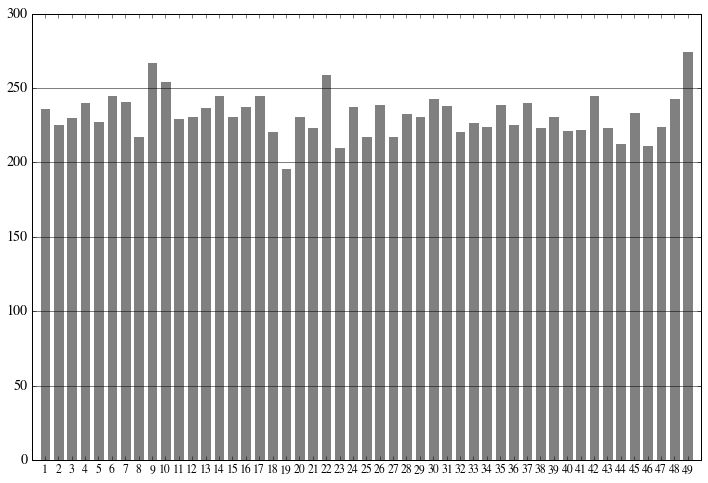

In [46]:
plt.bar(range(1,50), np.sum(r),align='center', color='grey')
plt.grid(b=True, which='major', axis='y', linestyle='-')
plt.xticks(range(1,50),size='small')
plt.show()

In [47]:
temp = pd.DataFrame()

In [48]:
temp['num'] = np.argsort(np.sum(r))[::-1]+1
temp['freq'] = np.sort(np.sum(r))[::-1]
temp['percentage'] = np.round(temp['freq'] / no_drawn_date * 100, 2)

In [52]:
#page = urllib.urlopen(url)
#soup = BeautifulSoup(page)

In [53]:
#a = soup.find(content=re.compile('The result is'))

In [54]:
#a['content'][a['content'].find('The result is')+14:a['content'].find('. Use Other')]

In [55]:
#result = []
#result = [url[58:],]
#soup.find_all(text=re.compile("^The result is$"))


In [56]:
#soup

In [57]:
#soup.select('.linename')